In [1]:
print("hi")

hi


In [2]:
import pandas as pd

DATA_DIR = 'Data'

train_transaction = pd.read_csv(f"{DATA_DIR}/train_transaction.csv")
train_identity    = pd.read_csv(f"{DATA_DIR}/train_identity.csv")

test_transaction  = pd.read_csv(f"{DATA_DIR}/test_transaction.csv")
test_identity     = pd.read_csv(f"{DATA_DIR}/test_identity.csv")

print("Train transaction shape:", train_transaction.shape)
print("Train identity shape:", train_identity.shape)
print("Test transaction shape:", test_transaction.shape)
print("Test identity shape:", test_identity.shape)

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Test transaction shape: (506691, 393)
Test identity shape: (141907, 41)


In [3]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')
train.head()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
train['DT_day'] = train['TransactionDT'] // (24 * 60 * 60)
train['DT_hour'] = (train['TransactionDT'] // (60 * 60)) % 24
train['DT_week'] = train['DT_day'] // 7
train['DT_month'] = train['DT_day'] // 30

In [5]:
# ==== BLOCK M1: Memory optimization & EDA sample ====

import numpy as np
import pandas as pd

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Initial memory usage: {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtypes

        # Skip if it's datetime
        if np.issubdtype(col_type, np.datetime64):
            continue

        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()

            # Integers
            if np.issubdtype(col_type, np.integer):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)

            # Floats
            else:
                if use_float16:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
                else:
                    # Default: float32 where possible
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        else:
            # Optionally convert object to category when cardinality reasonable
            if col_type == object:
                num_unique = df[col].nunique(dropna=True)
                num_total = len(df[col])
                # If less than 50% of rows are unique → good candidate for category
                if num_unique / max(1, num_total) < 0.5:
                    df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Final memory usage: {end_mem:.2f} MB")
    print(f"Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df


# 1. Apply memory reduction to full train
train = reduce_mem_usage(train, use_float16=False)

# 2. Create a smaller sample for EDA to avoid RAM crashes
EDA_SAMPLE_SIZE = 100000  # you can lower this to 150_000 if RAM is still an issue

if len(train) > EDA_SAMPLE_SIZE:
    train_eda = train.sample(EDA_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"\nCreated EDA sample with {len(train_eda)} rows (from {len(train)} total).")
else:
    train_eda = train.copy()
    print(f"\nDataset is small enough; using full data for EDA: {len(train_eda)} rows.")

# Quick check
print("\nSample shape:", train_eda.shape)
print("Columns:", len(train_eda.columns))


Initial memory usage: 2532.00 MB
Final memory usage: 927.23 MB
Decreased by 63.4%

Created EDA sample with 100000 rows (from 590540 total).

Sample shape: (100000, 438)
Columns: 438


In [6]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("Shape:", train_eda.shape)
print("\nColumns sample:", train_eda.columns[:15].tolist())

Shape: (100000, 438)

Columns sample: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2']


In [8]:
print("\nData types summary:")
print(train_eda.dtypes.value_counts())


Data types summary:
float32     399
category     12
int8          4
category      4
int32         2
int16         2
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64



Target value counts (isFraud):
isFraud
0    96424
1     3576
Name: count, dtype: int64

Target ratio (%):
isFraud
0    96.424
1     3.576
Name: proportion, dtype: float64


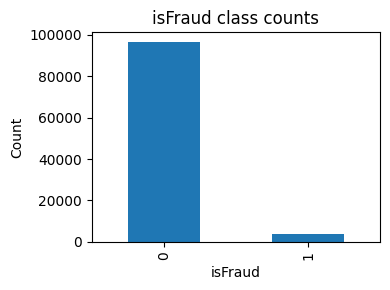

In [9]:
import matplotlib.pyplot as plt

target_counts = train_eda['isFraud'].value_counts(dropna=False)
target_ratio = train_eda['isFraud'].value_counts(normalize=True) * 100

print("\nTarget value counts (isFraud):")
print(target_counts)

print("\nTarget ratio (%):")
print(target_ratio.round(4))

# Simple bar plot of class imbalance
plt.figure(figsize=(4,3))
target_counts.sort_index().plot(kind='bar')
plt.title('isFraud class counts')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [10]:
missing = train_eda.isnull().mean().sort_values(ascending=False)
print("\nTop 20 columns by % missing:")
print(missing.head(20).apply(lambda x: f"{x*100:.2f}%"))


Top 20 columns by % missing:
id_24    99.24%
id_25    99.17%
id_21    99.17%
id_08    99.17%
id_07    99.17%
id_22    99.17%
id_23    99.17%
id_27    99.17%
id_26    99.17%
dist2    93.67%
D7       93.36%
id_18    92.44%
D13      89.61%
D14      89.48%
D12      89.12%
id_03    88.69%
id_04    88.69%
D6       87.66%
id_33    87.56%
D9       87.23%
dtype: object


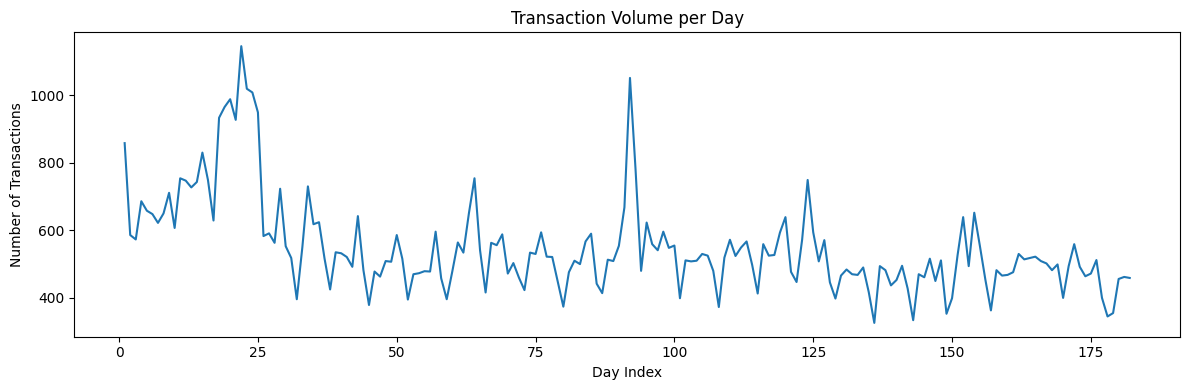

In [11]:
# 1. Plot transaction volume per day
plt.figure(figsize=(12,4))
train_eda.groupby('DT_day').size().plot()
plt.title('Transaction Volume per Day')
plt.xlabel('Day Index')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

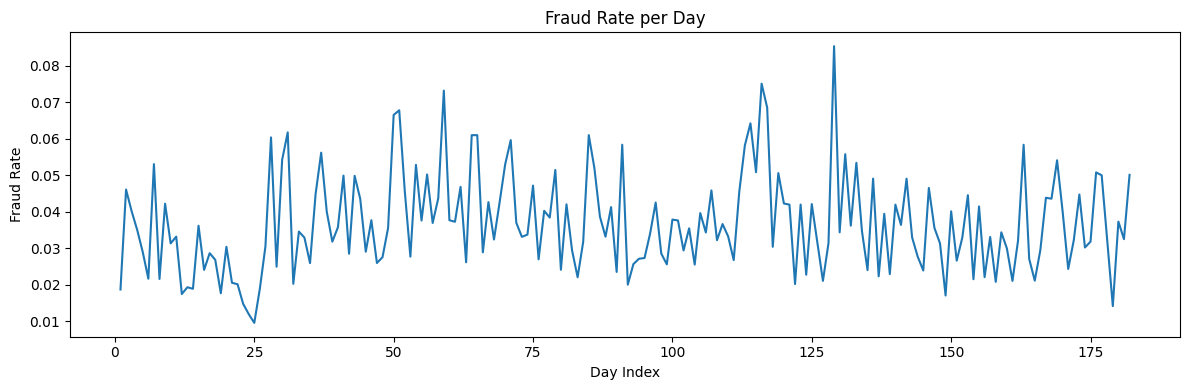

In [12]:
# 2. Plot fraud rate per day
plt.figure(figsize=(12,4))
daily_fraud = train_eda.groupby('DT_day')['isFraud'].mean()
daily_fraud.plot()
plt.title('Fraud Rate per Day')
plt.xlabel('Day Index')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

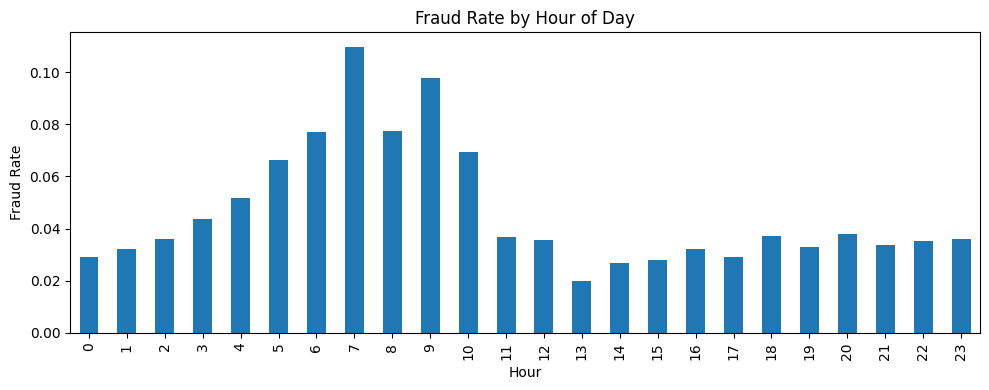

In [13]:
# 3. Fraud rate by hour of day (behavioral pattern)
plt.figure(figsize=(10,4))
hourly_fraud = train_eda.groupby('DT_hour')['isFraud'].mean()
hourly_fraud.plot(kind='bar')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

In [14]:
print("Created time features: DT_day, DT_hour")
print("\nDaily fraud rate (first 10 days):")
print(daily_fraud.head(10))

Created time features: DT_day, DT_hour

Daily fraud rate (first 10 days):
DT_day
1     0.018648
2     0.046075
3     0.040140
4     0.034985
5     0.028875
6     0.021605
7     0.053055
8     0.021538
9     0.042194
10    0.031301
Name: isFraud, dtype: float64


In [15]:
print("Basic stats for TransactionAmt:")
print(train_eda['TransactionAmt'].describe())

Basic stats for TransactionAmt:
count    100000.000000
mean        134.729156
std         253.990005
min           0.251000
25%          42.950001
50%          67.949997
75%         123.000000
max       31937.390625
Name: TransactionAmt, dtype: float64


In [17]:
import seaborn as sns

# Utility to plot distributions
def plot_distribution(feature, bins=100):
    plt.figure(figsize=(10,4))
    sns.histplot(train_eda[feature], bins=bins, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Utility to plot fraud vs non-fraud comparison
def plot_fraud_comparison(feature, bins=100):
    plt.figure(figsize=(10,4))
    sns.histplot(train_eda[feature][train_eda['isFraud']==0], bins=bins, color='blue', label='Not Fraud', alpha=0.5)
    sns.histplot(train_eda[feature][train_eda['isFraud']==1], bins=bins, color='red', label='Fraud', alpha=0.5)
    plt.title(f'{feature}: Fraud vs Not Fraud')
    plt.legend()
    plt.tight_layout()
    plt.show()

Basic stats for TransactionAmt:
count    100000.000000
mean        134.729156
std         253.990005
min           0.251000
25%          42.950001
50%          67.949997
75%         123.000000
max       31937.390625
Name: TransactionAmt, dtype: float64


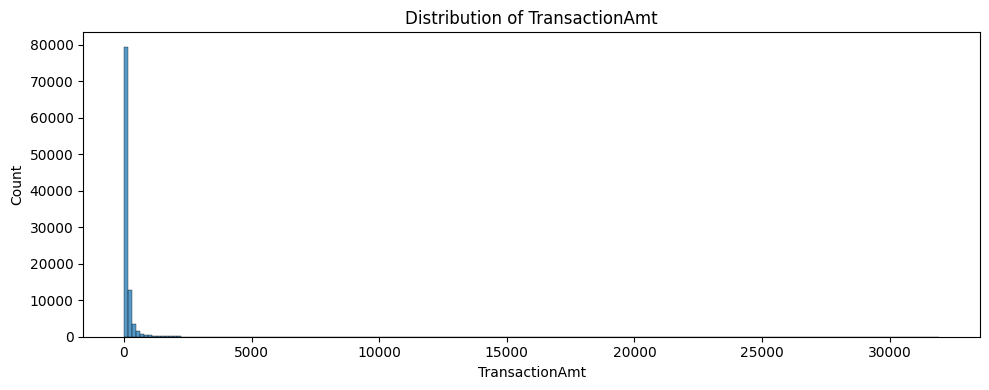

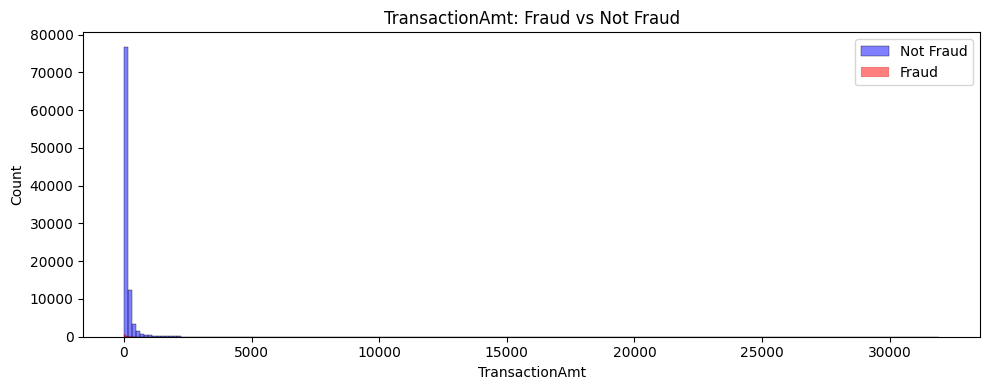

In [18]:
print("Basic stats for TransactionAmt:")
print(train_eda['TransactionAmt'].describe())

plot_distribution('TransactionAmt', bins=200)
plot_fraud_comparison('TransactionAmt', bins=200)


Card feature columns: ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

Analyzing card1:
count    100000.000000
mean       9901.775480
std        4912.393038
min        1007.000000
25%        6019.000000
50%        9692.000000
75%       14259.000000
max       18396.000000
Name: card1, dtype: float64


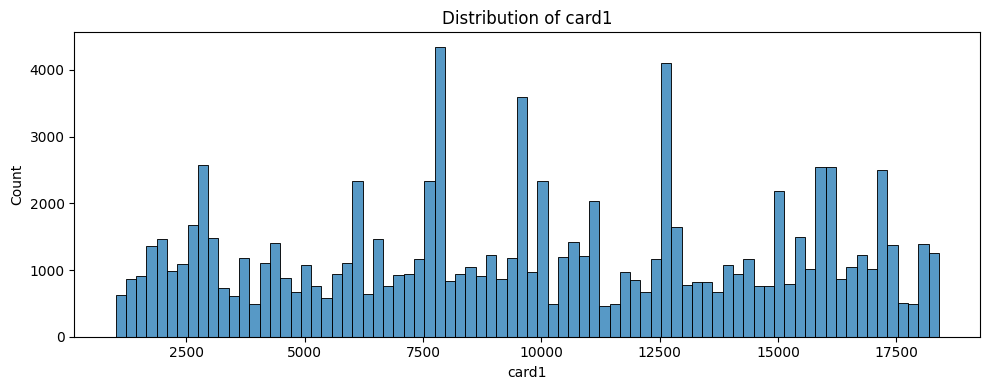

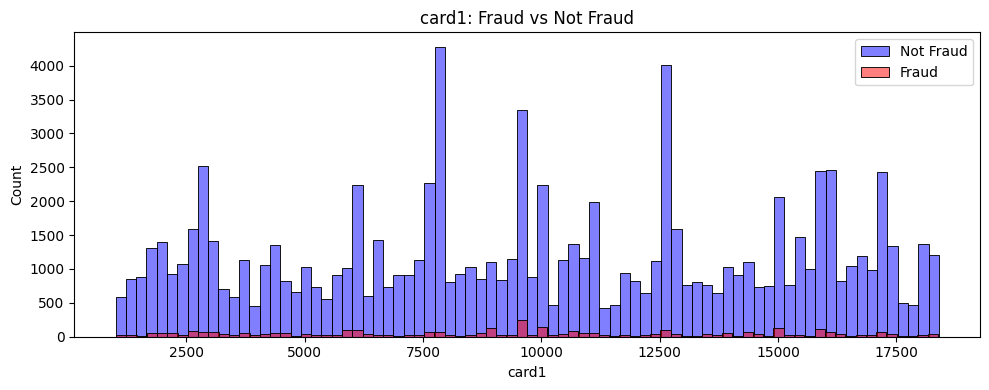


Analyzing card2:
count    98506.000000
mean       362.610931
std        157.895721
min        100.000000
25%        214.000000
50%        361.000000
75%        512.000000
max        600.000000
Name: card2, dtype: float64


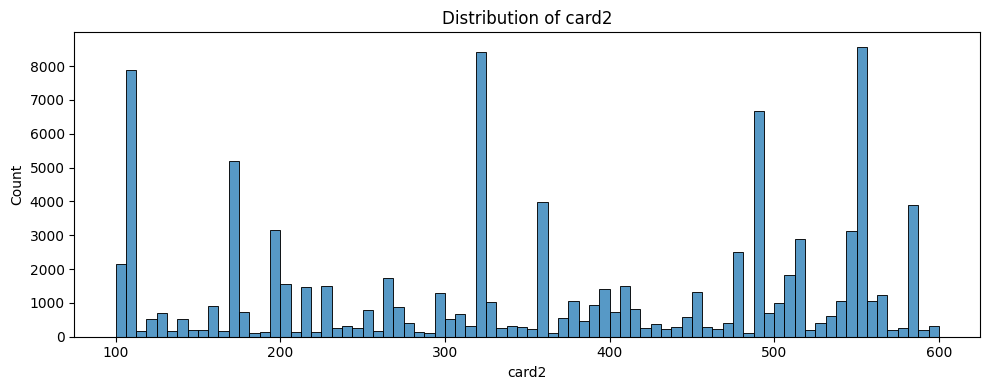

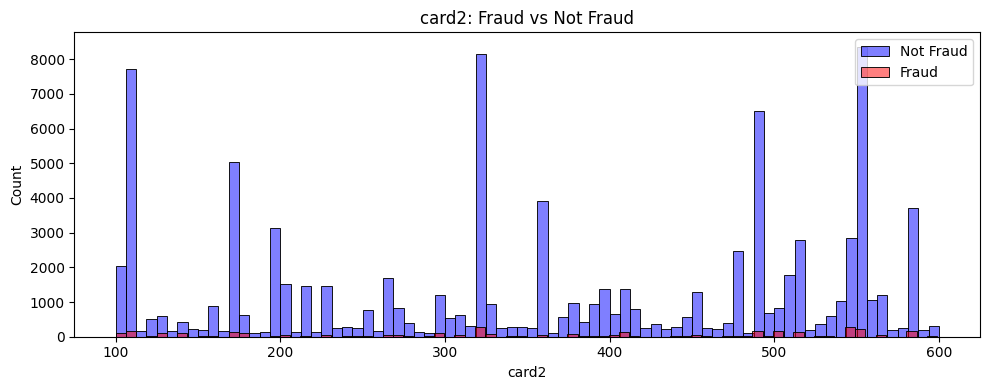


Analyzing card3:
count    99730.000000
mean       153.189331
std         11.326948
min        100.000000
25%        150.000000
50%        150.000000
75%        150.000000
max        231.000000
Name: card3, dtype: float64


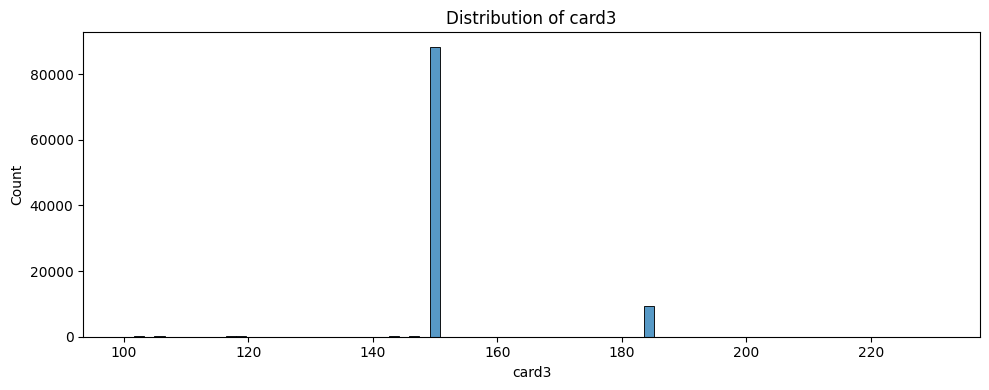

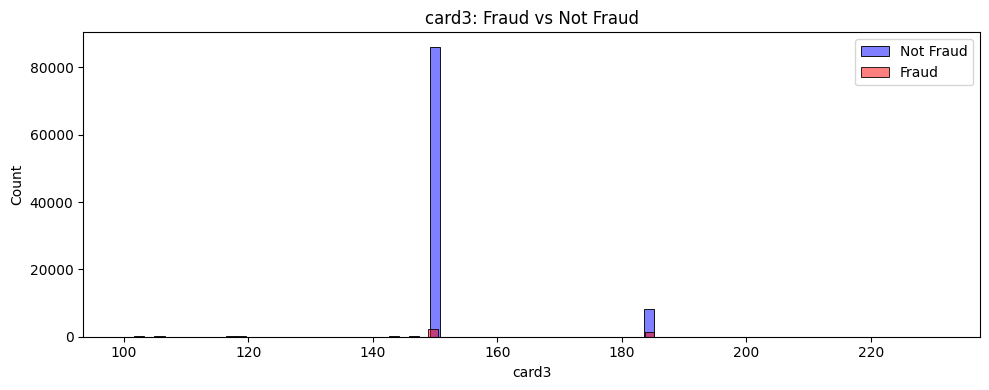


Analyzing card4:
count     99728
unique        4
top        visa
freq      64960
Name: card4, dtype: object


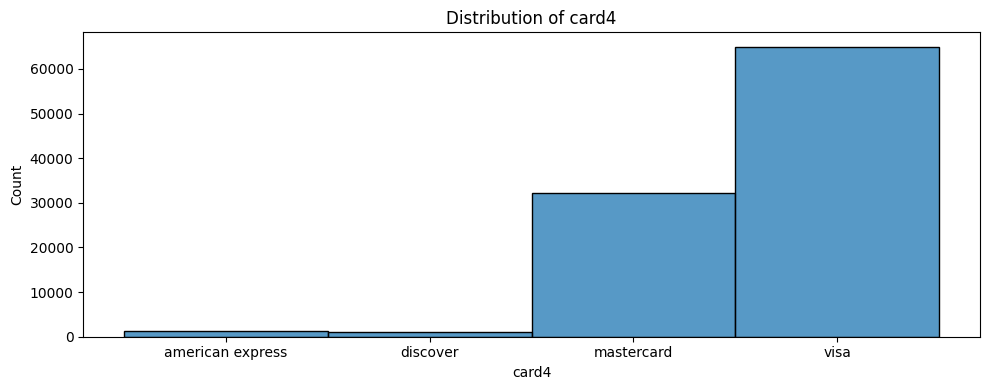

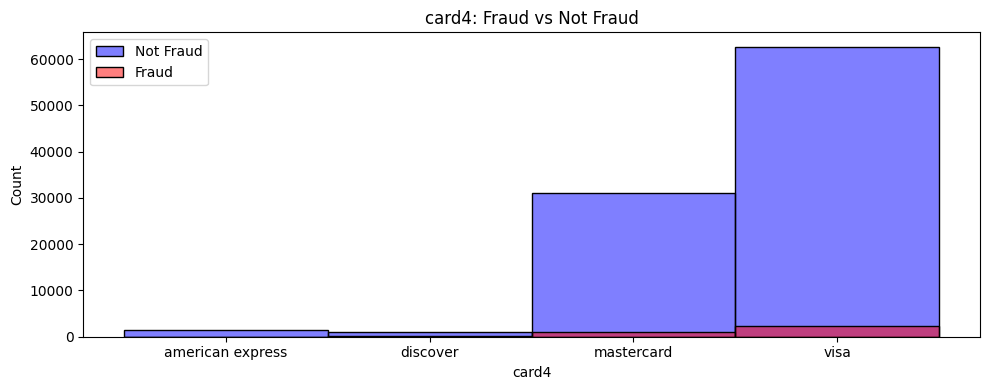


Analyzing card5:
count    99266.000000
mean       199.113083
std         41.414906
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64


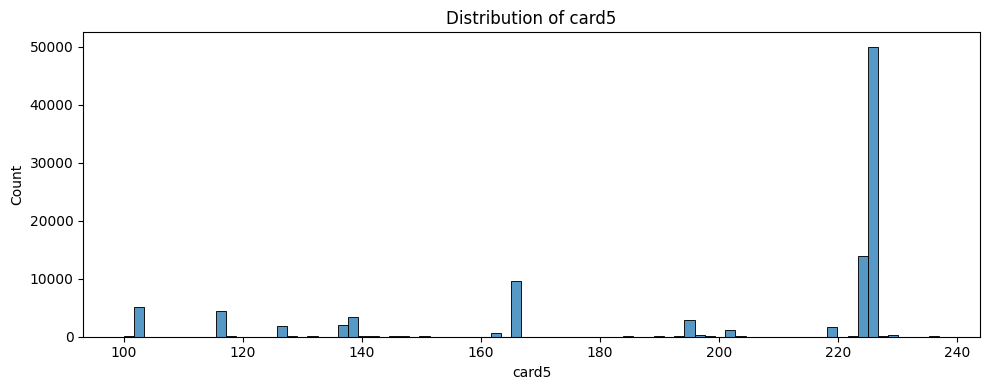

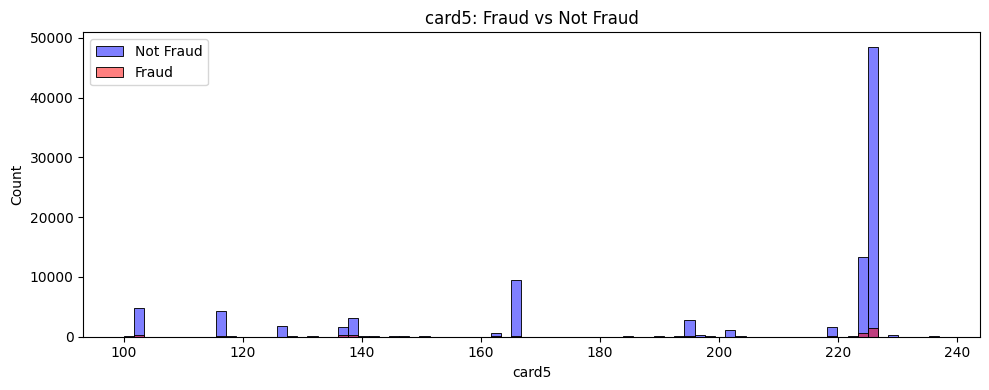


Analyzing card6:
count     99729
unique        4
top       debit
freq      74441
Name: card6, dtype: object


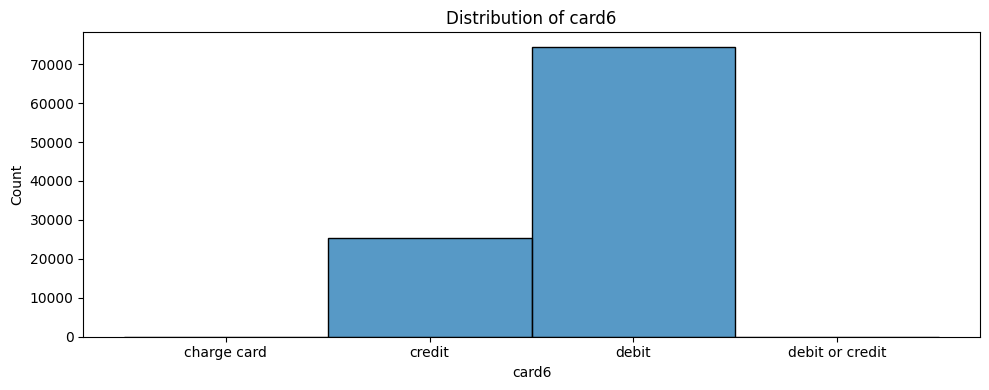

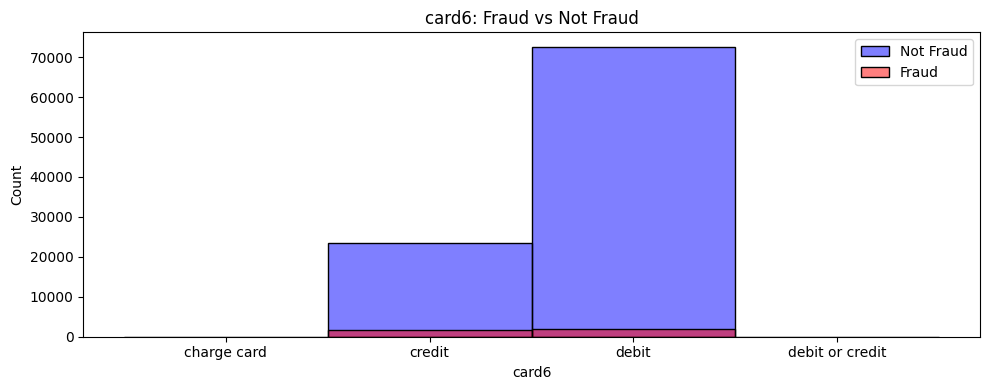

In [19]:
card_features = [c for c in train_eda.columns if c.startswith('card')]

print("\nCard feature columns:", card_features)

for c in card_features:
    print(f"\nAnalyzing {c}:")
    print(train_eda[c].describe())
    
    plot_distribution(c, bins=80)
    plot_fraud_comparison(c, bins=80)

In [20]:
train_eda.dtypes

TransactionID        int32
isFraud               int8
TransactionDT        int32
TransactionAmt     float32
ProductCD         category
                    ...   
DeviceInfo        category
DT_day               int16
DT_hour               int8
DT_week               int8
DT_month              int8
Length: 438, dtype: object

Found 407 numeric columns.
Using sample of 50000 rows for correlation computation.

Top positive correlations with isFraud:
isFraud    1.000000
V257       0.367829
V246       0.364745
V242       0.358803
V244       0.357643
V258       0.335907
V201       0.308520
V200       0.295899
V189       0.288947
V45        0.283508
V158       0.281152
V188       0.279729
V156       0.276184
V149       0.272751
V87        0.264900
Name: isFraud, dtype: float64

Top NEGATIVE correlations with isFraud:
V35     -0.084741
D2      -0.085618
id_07   -0.094231
V70     -0.102904
V30     -0.104837
V69     -0.106418
V91     -0.107939
V29     -0.110619
V90     -0.112845
V49     -0.117597
id_01   -0.118947
V48     -0.123482
D7      -0.130554
D8      -0.147617
V305          NaN
Name: isFraud, dtype: float64


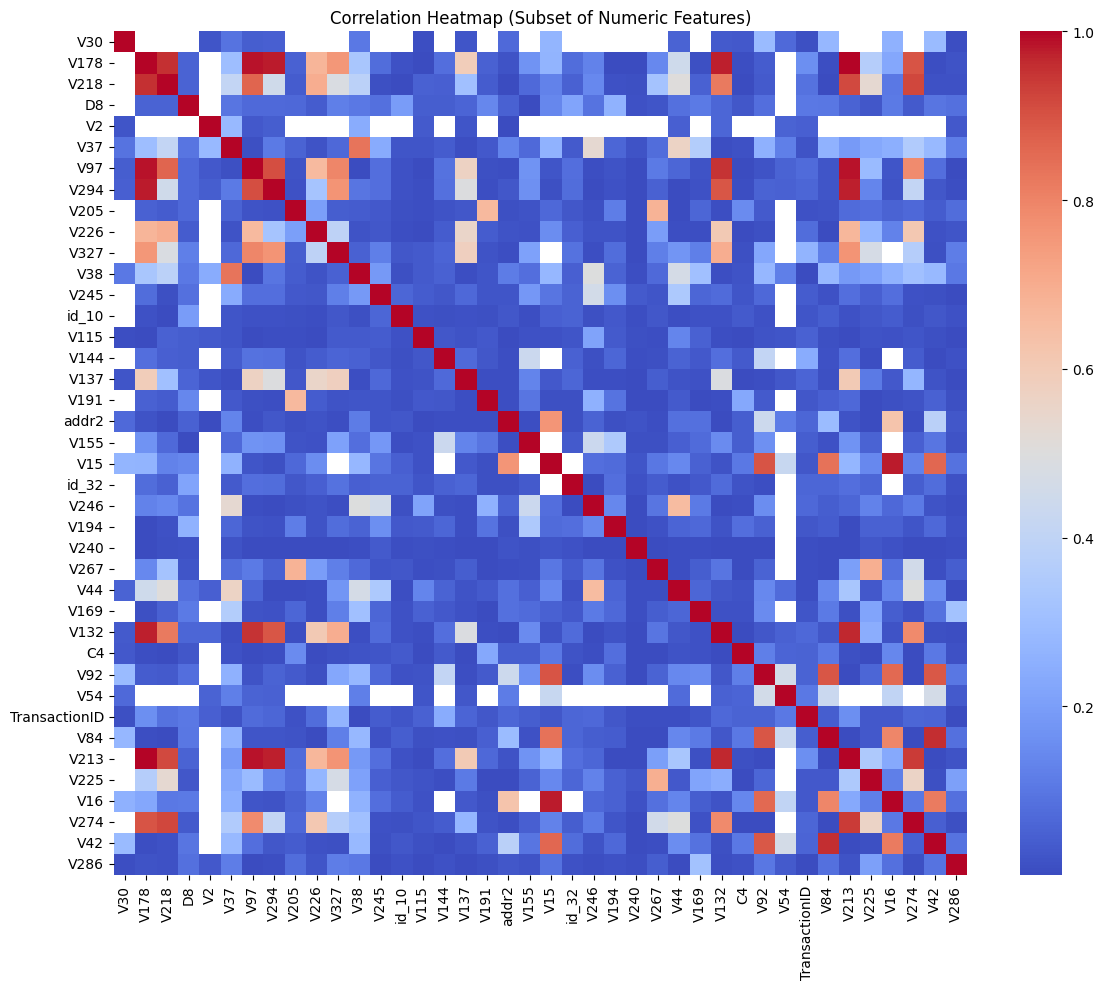

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select numeric columns from the EDA sample
numeric_cols = train_eda.select_dtypes(include=[np.number]).columns.tolist()
print(f"Found {len(numeric_cols)} numeric columns.")

# 2. Sample rows for performance
sample_size = min(50000, len(train_eda))
print(f"Using sample of {sample_size} rows for correlation computation.")

sample_df = train_eda[numeric_cols].sample(sample_size, random_state=42)

# 3. Correlation matrix
corr = sample_df.corr()

# 4. Focus on correlation with isFraud
if 'isFraud' in corr.columns:
    corr_target = corr['isFraud'].sort_values(ascending=False)
    print("\nTop positive correlations with isFraud:")
    print(corr_target.head(15))

    print("\nTop NEGATIVE correlations with isFraud:")
    print(corr_target.tail(15))
else:
    print("\nWARNING: 'isFraud' not found in correlation matrix columns.")

# 5. Heatmap on a subset of features (to avoid crashing)
max_features = 40
rows = min(max_features, corr.shape[0])
cols = min(max_features, corr.shape[1])

corr_abs = corr.abs()

# Sample a subset of rows/columns for visualization
corr_subset = corr_abs.sample(rows, axis=0, random_state=42).sample(cols, axis=1, random_state=42)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, cmap='coolwarm')
plt.title("Correlation Heatmap (Subset of Numeric Features)")
plt.tight_layout()
plt.show()


In [22]:
# Identify categorical columns & cardinality

cat_cols = train_eda.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"Found {len(cat_cols)} categorical columns.")

# Calculate cardinality
cat_cardinality = {col: train_eda[col].nunique(dropna=True) for col in cat_cols}
cat_cardinality = dict(sorted(cat_cardinality.items(), key=lambda x: x[1], reverse=True))

print("\nTop 20 categorical features by cardinality:")
for k, v in list(cat_cardinality.items()):
    print(f"{k}: {v} unique values")


Found 31 categorical columns.

Top 20 categorical features by cardinality:
DeviceInfo: 1019 unique values
id_33: 128 unique values
id_31: 112 unique values
id_30: 72 unique values
P_emaildomain: 59 unique values
R_emaildomain: 59 unique values
ProductCD: 5 unique values
card4: 4 unique values
card6: 4 unique values
id_34: 4 unique values
M4: 3 unique values
id_15: 3 unique values
id_23: 3 unique values
M1: 2 unique values
M2: 2 unique values
M3: 2 unique values
M5: 2 unique values
M6: 2 unique values
M7: 2 unique values
M8: 2 unique values
M9: 2 unique values
id_12: 2 unique values
id_16: 2 unique values
id_27: 2 unique values
id_28: 2 unique values
id_29: 2 unique values
id_35: 2 unique values
id_36: 2 unique values
id_37: 2 unique values
id_38: 2 unique values
DeviceType: 2 unique values


In [23]:
# Select important categorical features

important_cat = [
    'ProductCD', 'card4', 'card6',
    'addr1', 'addr2',
    'P_emaildomain', 'R_emaildomain',
    'DeviceType', 'DeviceInfo'
]

important_cat = [c for c in important_cat if c in train_eda.columns]

print("Important categorical features found:")
print(important_cat)


Important categorical features found:
['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


In [24]:
# Show value counts of important categorical features

for col in important_cat:
    print(f"\n=== {col} ===")
    print(train_eda[col].value_counts(dropna=False).head(10))


=== ProductCD ===
ProductCD
W    74466
C    11528
R     6374
H     5564
S     2068
Name: count, dtype: int64

=== card4 ===
card4
visa                64960
mastercard          32243
american express     1393
discover             1132
NaN                   272
Name: count, dtype: int64

=== card6 ===
card6
debit              74441
credit             25279
NaN                  271
debit or credit        6
charge card            3
Name: count, dtype: int64

=== addr1 ===
addr1
NaN      11012
299.0     7879
325.0     7350
204.0     7183
264.0     6619
330.0     4501
315.0     3980
441.0     3493
272.0     3409
123.0     2709
Name: count, dtype: int64

=== addr2 ===
addr2
87.0    88233
NaN     11012
60.0      550
96.0      102
32.0       16
65.0       13
31.0        7
16.0        5
19.0        4
34.0        4
Name: count, dtype: int64

=== P_emaildomain ===
P_emaildomain
gmail.com        38619
yahoo.com        17031
NaN              16163
hotmail.com       7525
anonymous.com     6276
aol.c


Plotting fraud rate for ProductCD...


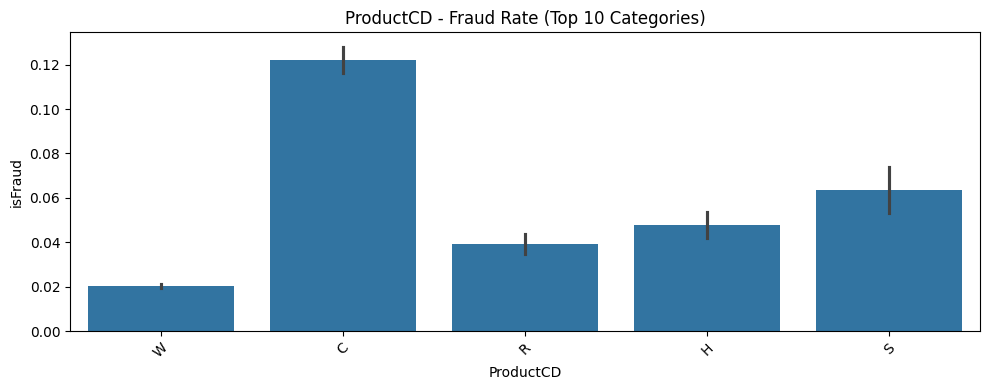


Plotting fraud rate for card4...


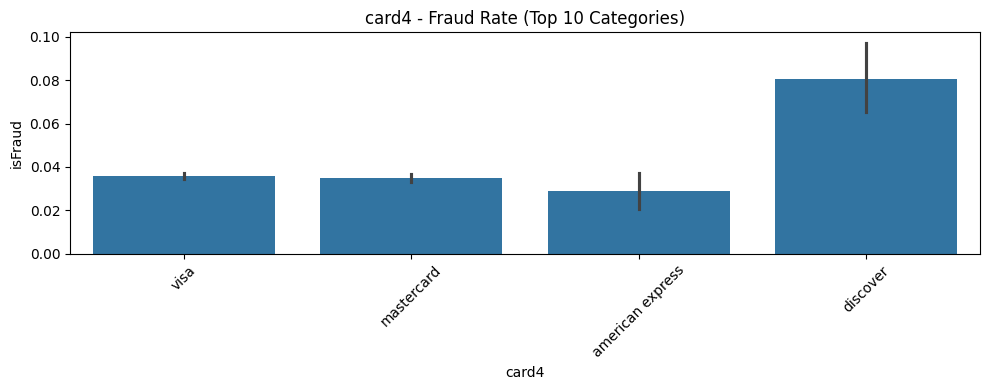


Plotting fraud rate for card6...


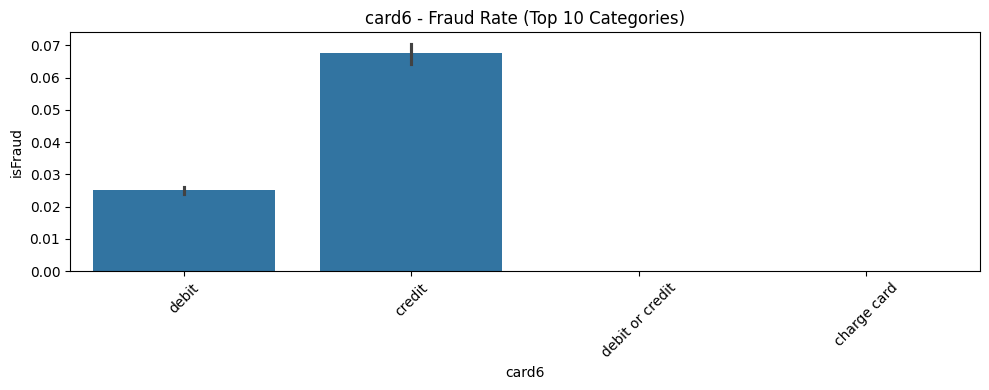


Plotting fraud rate for addr1...


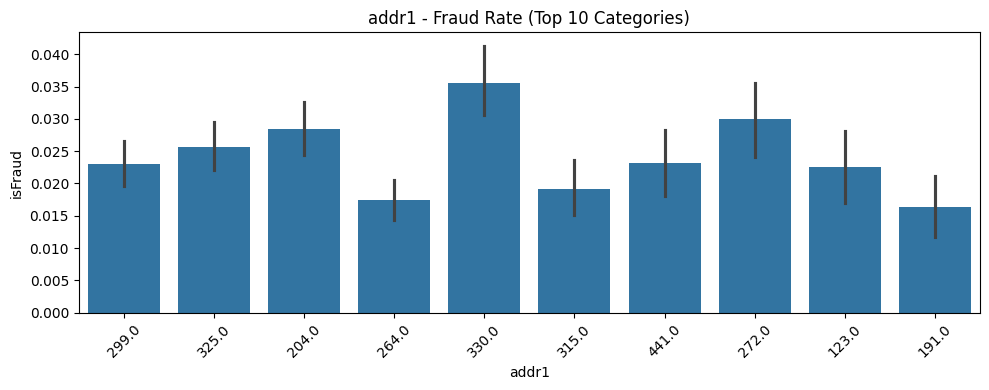


Plotting fraud rate for addr2...


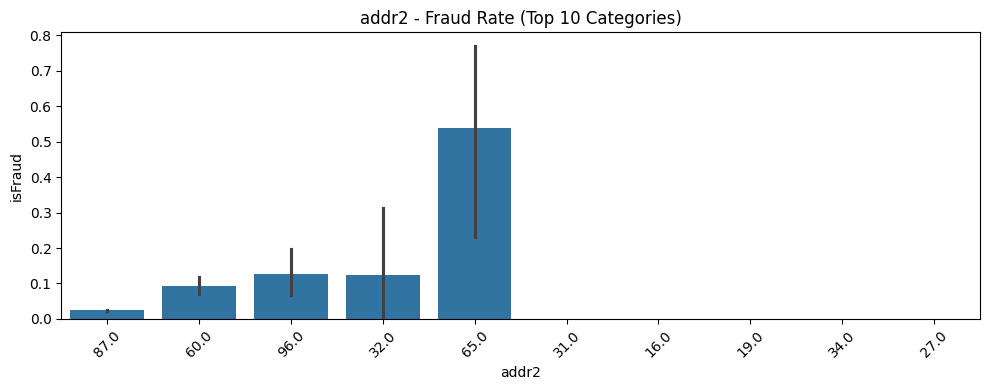


Plotting fraud rate for P_emaildomain...


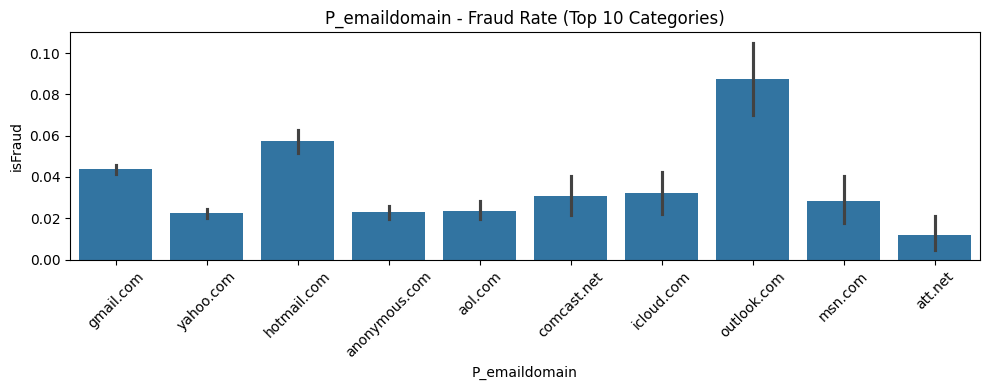


Plotting fraud rate for R_emaildomain...


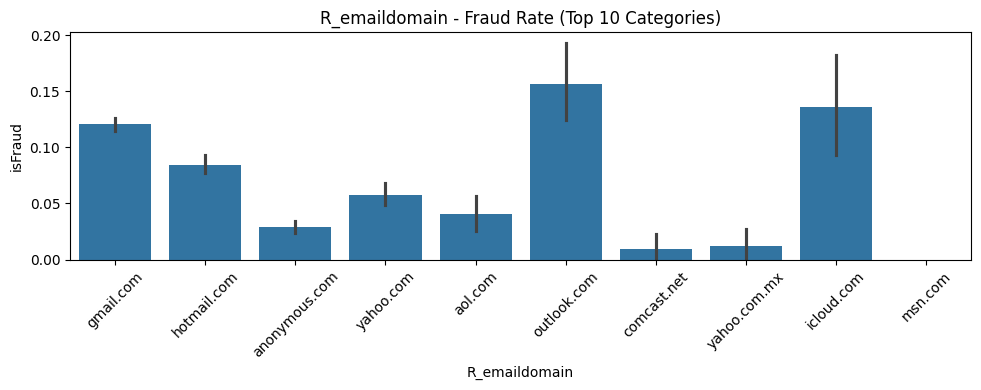


Plotting fraud rate for DeviceType...


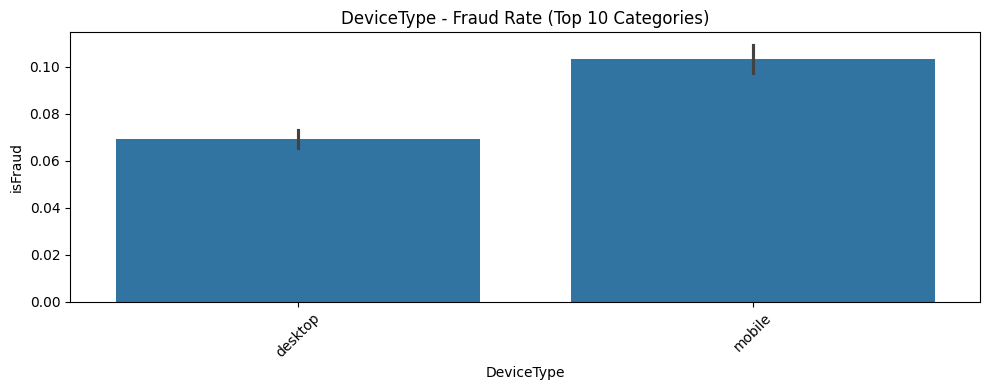


Plotting fraud rate for DeviceInfo...


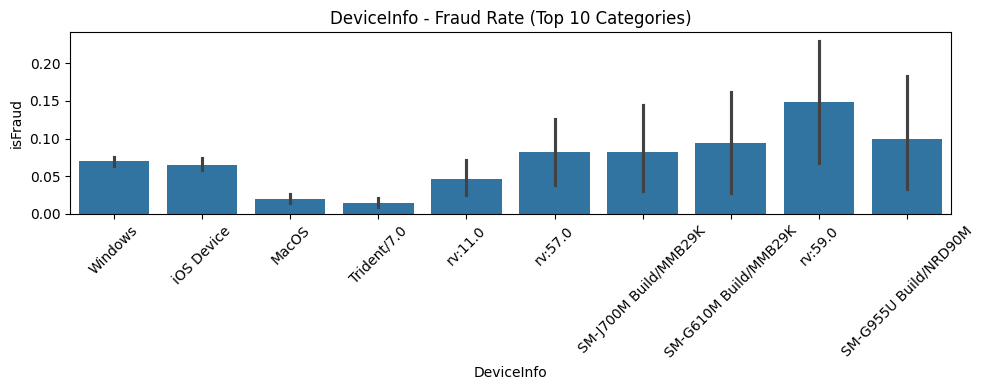

In [25]:
# Fraud rate by category (Top 10)

import matplotlib.pyplot as plt
import seaborn as sns

for col in important_cat:
    print(f"\nPlotting fraud rate for {col}...")

    top_vals = train_eda[col].value_counts().head(10).index
    tmp = train_eda[train_eda[col].isin(top_vals)]

    plt.figure(figsize=(10,4))
    sns.barplot(
        data=tmp,
        x=col,
        y='isFraud',
        estimator=lambda x: sum(x) / len(x),
        order=top_vals
    )
    plt.title(f"{col} - Fraud Rate (Top 10 Categories)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [26]:
# Missing percent for all columns

missing = train_eda.isnull().mean().sort_values(ascending=False)
missing_df = missing.to_frame(name='missing_ratio')
missing_df['missing_percentage'] = (missing_df['missing_ratio'] * 100).round(2)

print("Top 25 columns by missing %:")
missing_df.head(25)


Top 25 columns by missing %:


,missing_ratio,missing_percentage
id_24,0.99240,99.24
id_25,0.99174,99.17
id_21,0.99172,99.17
id_08,0.99172,99.17
id_07,0.99172,99.17
id_22,0.99170,99.17
id_23,0.99170,99.17
id_27,0.99170,99.17
id_26,0.99170,99.17
dist2,0.93671,93.67


In [27]:
# Missing threshold summary

print("Columns with >90% missing:", (missing > 0.90).sum())
print("Columns with 70–90% missing:", ((missing > 0.70) & (missing <= 0.90)).sum())
print("Columns with 40–70% missing:", ((missing > 0.40) & (missing <= 0.70)).sum())
print("Columns with <40% missing:", (missing <= 0.40).sum())


Columns with >90% missing: 12
Columns with 70–90% missing: 196
Columns with 40–70% missing: 24
Columns with <40% missing: 206


In [28]:
# Group columns into logical families

V_cols = [c for c in train_eda.columns if c.startswith('V')]
D_cols = [c for c in train_eda.columns if c.startswith('D')]
id_cols = [c for c in train_eda.columns if c.startswith('id_')]
card_cols = [c for c in train_eda.columns if c.startswith('card')]
addr_cols = [c for c in train_eda.columns if c.startswith('addr')]

print("V features:", len(V_cols))
print("D features:", len(D_cols))
print("ID features:", len(id_cols))
print("Card features:", len(card_cols))
print("Address features:", len(addr_cols))


V features: 339
D features: 21
ID features: 38
Card features: 6
Address features: 2


In [29]:
# CELL 5.4 — Missing % by feature group

def missing_group(cols):
    miss = train_eda[cols].isnull().mean().mean() * 100
    return round(miss, 2)

print("Avg missing % — V features :", missing_group(V_cols))
print("Avg missing % — D features :", missing_group(D_cols))
print("Avg missing % — ID features:", missing_group(id_cols))
print("Avg missing % — Card features:", missing_group(card_cols))
print("Avg missing % — Addr features:", missing_group(addr_cols))


Avg missing % — V features : 43.05
Avg missing % — D features : 48.98
Avg missing % — ID features: 84.83
Avg missing % — Card features: 0.51
Avg missing % — Addr features: 11.01


In [30]:
numeric_cols_all = train_eda.select_dtypes(include=[np.number]).columns.tolist()

# Intersect groups with numeric columns only
V_num_cols    = [c for c in V_cols   if c in numeric_cols_all]
D_num_cols    = [c for c in D_cols   if c in numeric_cols_all]
id_num_cols   = [c for c in id_cols  if c in numeric_cols_all]
card_num_cols = [c for c in card_cols if c in numeric_cols_all]
addr_num_cols = [c for c in addr_cols if c in numeric_cols_all]

print("Numeric V cols   :", len(V_num_cols))
print("Numeric D cols   :", len(D_num_cols))
print("Numeric id cols  :", len(id_num_cols))
print("Numeric card cols:", len(card_num_cols))
print("Numeric addr cols:", len(addr_num_cols))

# Fill numeric missing with -1
train_eda[V_num_cols]    = train_eda[V_num_cols].fillna(-1)
train_eda[D_num_cols]    = train_eda[D_num_cols].fillna(-1)
train_eda[id_num_cols]   = train_eda[id_num_cols].fillna(-1)
train_eda[card_num_cols] = train_eda[card_num_cols].fillna(-1)
train_eda[addr_num_cols] = train_eda[addr_num_cols].fillna(-1)

print("Numeric missing values filled with -1 (only numeric dtypes).")

Numeric V cols   : 339
Numeric D cols   : 19
Numeric id cols  : 23
Numeric card cols: 4
Numeric addr cols: 2
Numeric missing values filled with -1 (only numeric dtypes).


In [31]:
# Fill categorical missing values safely

import pandas as pd
cat_cols_existing = train_eda.select_dtypes(include=['category']).columns.tolist()

print(f"Category columns : {len(cat_cols_existing)}")

# 2) Handle existing category columns: add 'missing' category then fill
for c in cat_cols_existing:
    # ensure 'missing' is in the categories
    if 'missing' not in train_eda[c].cat.categories:
        train_eda[c] = train_eda[c].cat.add_categories(['missing'])
    train_eda[c] = train_eda[c].fillna('missing')

print("Categorical missing values filled; all object columns converted to 'category'.")

Category columns : 31
Categorical missing values filled; all object columns converted to 'category'.


In [32]:
# Log-transform TransactionAmt (smoother distribution)

import numpy as np

if 'TransactionAmt' in train_eda.columns:
    train_eda['TransactionAmt_log'] = np.log1p(train_eda['TransactionAmt'])
    train_eda['TransactionAmt_sqrt'] = np.sqrt(train_eda['TransactionAmt'])
    print("Created TransactionAmt_log feature.")
else:
    print("TransactionAmt column not found.")


Created TransactionAmt_log feature.


C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\618343954.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda['TransactionAmt_log'] = np.log1p(train_eda['TransactionAmt'])
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\618343954.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda['TransactionAmt_sqrt'] = np.sqrt(train_eda['TransactionAmt'])


In [33]:
# Confirm missing values are handled

final_missing = (train_eda.isnull().mean() * 100).sort_values(ascending=False)
print("Top 20 features by missing % after preprocessing:")
print(final_missing.head(20))


Top 20 features by missing % after preprocessing:
dist2             93.671
dist1             59.650
TransactionID      0.000
isFraud            0.000
TransactionDT      0.000
TransactionAmt     0.000
ProductCD          0.000
card1              0.000
id_31              0.000
id_16              0.000
id_17              0.000
id_18              0.000
id_19              0.000
id_20              0.000
id_21              0.000
id_22              0.000
id_23              0.000
id_24              0.000
id_25              0.000
id_26              0.000
dtype: float64


In [34]:
train_eda['dist1'] = train_eda['dist1'].fillna(-1)
train_eda = train_eda.drop(columns=['dist2']) 

In [35]:
# Frequency encoding for important high-cardinality categorical features

freq_encode_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

for col in freq_encode_cols:
    if col in train_eda.columns:
        freq = train_eda[col].value_counts()
        train_eda[col + '_freq'] = train_eda[col].map(freq)
        print(f"Created frequency encoding for {col}")


Created frequency encoding for card1
Created frequency encoding for card2
Created frequency encoding for card3
Created frequency encoding for card4
Created frequency encoding for card5
Created frequency encoding for card6
Created frequency encoding for addr1
Created frequency encoding for addr2


C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\3052607522.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda[col + '_freq'] = train_eda[col].map(freq)
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\3052607522.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda[col + '_freq'] = train_eda[col].map(freq)
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\3052607522.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [36]:
# Rare category grouping for email & device

rare_threshold = 100  # categories with <100 occurrences become "rare"

group_cols = ['P_emaildomain', 'R_emaildomain', 'DeviceInfo', 'DeviceType']

for col in group_cols:
    if col in train_eda.columns:
        freq = train_eda[col].value_counts()
        rare_vals = freq[freq < rare_threshold].index
        train_eda[col] = train_eda[col].replace(rare_vals, "rare")
        print(f"Grouped rare categories (<{rare_threshold}) for {col}")


Grouped rare categories (<100) for P_emaildomain
Grouped rare categories (<100) for R_emaildomain
Grouped rare categories (<100) for DeviceInfo
Grouped rare categories (<100) for DeviceType


C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\2308062862.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_eda[col] = train_eda[col].replace(rare_vals, "rare")
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\2308062862.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_eda[col] = train_eda[col].replace(rare_vals, "rare")
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\2308062862.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for c

In [37]:
# Count encodings (aggregated features)

agg_cols = ['card1', 'card2', 'P_emaildomain', 'R_emaildomain', 'DeviceInfo']

for col in agg_cols:
    if col in train_eda.columns:
        train_eda[col + "_count"] = train_eda[col].map(train_eda[col].value_counts())
        print(f"Created count feature for {col}")


Created count feature for card1
Created count feature for card2
Created count feature for P_emaildomain
Created count feature for R_emaildomain
Created count feature for DeviceInfo


C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\959778596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda[col + "_count"] = train_eda[col].map(train_eda[col].value_counts())
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\959778596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_eda[col + "_count"] = train_eda[col].map(train_eda[col].value_counts())
C:\Users\Rahm\AppData\Local\Temp\ipykernel_20356\959778596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [38]:
# Preview engineered features
train_eda.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card4_freq,card5_freq,card6_freq,addr1_freq,addr2_freq,card1_count,card2_count,P_emaildomain_count,R_emaildomain_count,DeviceInfo_count
0,3457624,0,12153579,724.000000,W,7826,481.0,150.0,mastercard,224.0,...,32243,13846,74441,1431,88233,519,1098,4896,76769,79940
1,3552820,0,15005886,108.500000,W,12544,321.0,150.0,visa,226.0,...,64960,50003,74441,1562,88233,1109,8200,17031,76769,79940
2,3271083,0,6970178,47.950001,W,9400,111.0,150.0,mastercard,224.0,...,32243,13846,74441,3980,88233,136,7757,38619,76769,79940
3,3226689,0,5673658,100.598999,C,15885,545.0,185.0,visa,138.0,...,64960,3386,74441,11012,11012,1782,2797,38619,9782,79940
4,3268855,0,6886780,107.949997,W,15497,490.0,150.0,visa,226.0,...,64960,50003,74441,7879,88233,681,6440,7525,76769,79940


In [39]:
# AWS CELL 1 — Define numeric and categorical feature lists

import numpy as np

TARGET = 'isFraud'

# Drop columns we don't want to feed to the model
drop_cols = ['TransactionID', 'TransactionDT']

drop_cols = [c for c in drop_cols if c in train_eda.columns]

X_full = train_eda.drop(columns=drop_cols + [TARGET])
y_full = train_eda[TARGET].astype(int)

numeric_features = X_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_full.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 413
Categorical features: 36


In [44]:
# AWS CELL 2 — Build preprocessing + model pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# Preprocessor: numeric passthrough, categorical → ordinal ints
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ]
)

# Classifier: LightGBM with reasonable defaults (you can paste your tuned params here)
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
)

# Full pipeline: preprocess → model
pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', lgb_clf)
    ]
)

print("Pipeline created.")


Pipeline created.


In [45]:
# AWS CELL 3 — Train pipeline and quick eval

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

pipeline.fit(X_train_p, y_train_p)

valid_pred_p = pipeline.predict_proba(X_valid_p)[:, 1]

roc = roc_auc_score(y_valid_p, valid_pred_p)
precision, recall, _ = precision_recall_curve(y_valid_p, valid_pred_p)
pr_auc = auc(recall, precision)

print(f"Pipeline ROC-AUC: {roc:.5f}")
print(f"Pipeline PR-AUC : {pr_auc:.5f}")


[LightGBM] [Info] Number of positive: 2861, number of negative: 77139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35680
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035763 -> initscore=-3.294438
[LightGBM] [Info] Start training from score -3.294438


c:\Users\Rahm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Pipeline ROC-AUC: 0.93348
Pipeline PR-AUC : 0.69498


In [46]:
# AWS CELL 4 — Save trained pipeline artifact

import joblib
import os

os.makedirs("model_artifacts", exist_ok=True)

model_path = "model_artifacts/fraud_pipeline.joblib"
joblib.dump(pipeline, model_path)

print(f"Saved pipeline to: {model_path}")


Saved pipeline to: model_artifacts/fraud_pipeline.joblib
